In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from src.models import combined_cnn
from src.generator import generator_two_inputs
from src.loss import smoothed_binary_crossentropy
sys.path.append('/notebook')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline

/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1ty

In [2]:
# import dataframe with filenames and labels
sample = pd.read_csv('../labels/training_labels_updated_111219.csv')
sample['temp_label'] = sample['final_label'].apply(lambda x: np.round(x))
sample['temp_label'] = sample['temp_label'].astype('int').astype('str')
sample['final_label'] =  sample['final_label'].astype('str')

train_data, test_data = train_test_split(sample, test_size = 0.2, random_state = 10)

In [3]:
# # import dataframe with filenames and labels
# labels = pd.read_csv('../labels/training_labels.csv')
# labels['full_label'] = 'aerial_' + labels['AERIAL_Driveway'].astype(int).astype(str) + \
#                        '_gsv_' + labels['GSV_Driveway'].astype(int).astype(str)
# # use train test split
# train_data, test_data = train_test_split(labels, test_size = 0.25, random_state = 100)

In [4]:
# train_data = train_data[train_data.final_label != '0.5']

In [5]:
train_data.shape, test_data.shape

((390, 10), (98, 10))

In [6]:
train_data.groupby('temp_label').aggregate({'ADDR_NUM':len})

,ADDR_NUM
temp_label,
0,89
1,301


Class imbalance, so upsampling

In [7]:
# artificially oversample the minority class
zero_class = train_data[train_data.temp_label == '0']
train_data = (train_data.append(zero_class)).append(zero_class)

In [8]:
# input parameters
batch_size = 8
epochs = 10

In [9]:
model = combined_cnn(gsv_image_dim = (128,128, 3), sat_image_dim = ((128,128, 4)), 
                     n_classes = 1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gsv_image_input (InputLayer)    (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
aerial_image_input (InputLayer) (None, 128, 128, 4)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 128 3584        gsv_image_input[0][0]            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 126, 126, 128 4736        aerial_image_input[0][0]         
__________________________________________________________________________________________________
max_poolin

In [10]:
#implement class weights as an easy first attempt to handle imbalanced class problem
class_weight = {1.0: 1,
                0.0: 2}

In [11]:
history = model.fit_generator(
                # train 
                generator_two_inputs(train_data, aerial_dir = '../data/training/aerial_images/', 
                gsv_dir ='../data/training/sv_images/', batch_size = batch_size, 
                gsv_image_dim = (128,128, 3), aer_image_dim = (128,128, 4), y_column = 'temp_label'),
                
                validation_data=generator_two_inputs(test_data, aerial_dir = '../data/training/aerial_images/', 
                gsv_dir ='../data/training/sv_images/', batch_size = batch_size, 
                gsv_image_dim = (128,128, 3), aer_image_dim = (128,128, 4), y_column = 'temp_label'),
                
                validation_steps = 5,
                steps_per_epoch=np.ceil(sample.shape[0]//batch_size), 
                epochs=epochs,
#                 class_weight = class_weight,
                verbose=1)

Epoch 1/10
Found 568 validated image filenames belonging to 2 classes.
Found 568 validated image filenames belonging to 2 classes.
60/61 [============================>.] - ETA: 1s - loss: 1.8386 - acc: 0.5292 - sensitivity: 0.5383 - specificity: 0.4875Found 98 validated image filenames belonging to 2 classes.
Found 98 validated image filenames belonging to 2 classes.
61/61 [==============================] - 110s 2s/step - loss: 1.8333 - acc: 0.5266 - sensitivity: 0.5295 - specificity: 0.4893 - val_loss: 1.8895 - val_acc: 0.3750 - val_sensitivity: 0.2905 - val_specificity: 0.9000
Epoch 2/10
42/61 [===================>..........] - ETA: 26s - loss: 1.4462 - acc: 0.5536 - sensitivity: 0.5730 - specificity: 0.5690

KeyboardInterrupt: 

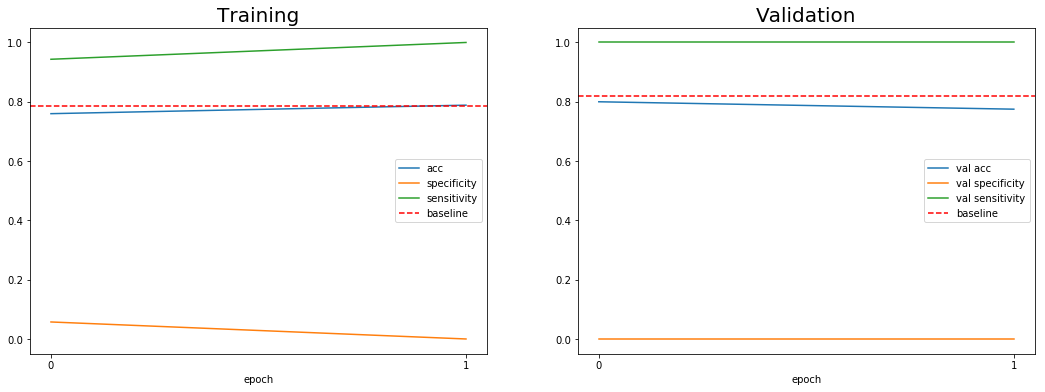

In [11]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1); plt.title('Training', fontsize = 20)
plt.plot(history.history['acc'], label = 'acc')
plt.plot(history.history['specificity'], label = 'specificity')
plt.plot(history.history['sensitivity'], label = 'sensitivity')
plt.axhline((train_data.temp_label).astype('float32').sum()/train_data.shape[0], ls = '--', c = 'r', label = 'baseline')
plt.xticks(np.arange(0,epochs)); plt.xlabel('epoch')
plt.legend()
plt.subplot(1,2,2); plt.title('Validation', fontsize = 20)
plt.plot(history.history['val_acc'], label = 'val acc')
plt.plot(history.history['val_specificity'], label = 'val specificity')
plt.plot(history.history['val_sensitivity'], label = 'val sensitivity')
plt.axhline((test_data.temp_label).astype('float32').sum()/test_data.shape[0], ls = '--', c = 'r', label = 'baseline')
plt.xticks(np.arange(0,epochs));plt.xlabel('epoch')
plt.legend();

In [12]:
addresses_gsv_filename = ['1_ESSEX_ST.jpg', '8_GILMAN_ST.jpg', '9_MELVILLE_RD.jpg','10_CENTRAL_ST.jpg',
                         '14_MANSFIELD_ST.jpg']
pred_sample = sample[sample.gsv_filename.isin(addresses_gsv_filename)]
pred_sample

,ADDR_NUM,FULL_STR,MBL,ADDRESS_FOR_STREET_VIEW,AERIAL_Driveway,GSV_Driveway,final_label,aerial_filename,gsv_filename,temp_label
0,1,ESSEX ST,50-B-12,"1 ESSEX ST, SOMERVILLE, MA",2,1,0.9,1_ESSEX_ST_aerial.png,1_ESSEX_ST.jpg,1
25,8,GILMAN ST,92-J-10,"8 GILMAN ST, SOMERVILLE, MA",1,2,0.9,8_GILMAN_ST_aerial.png,8_GILMAN_ST.jpg,1
37,9,MELVILLE RD,55-C-13,"9 MELVILLE RD, SOMERVILLE, MA",1,1,1.0,9_MELVILLE_RD_aerial.png,9_MELVILLE_RD.jpg,1
51,10,CENTRAL ST,44-F-8,"10 CENTRAL ST, SOMERVILLE, MA",0,0,0.0,10_CENTRAL_ST_aerial.png,10_CENTRAL_ST.jpg,0
78,14,MANSFIELD ST,81-B-16,"14 MANSFIELD ST, SOMERVILLE, MA",2,2,0.5,14_MANSFIELD_ST_aerial.png,14_MANSFIELD_ST.jpg,0


In [13]:
model.predict_generator(generator_two_inputs(pred_sample, aerial_dir = '../data/training/aerial_images/', 
                gsv_dir ='../data/training/sv_images/', batch_size = batch_size, 
                 gsv_image_dim = (128,128, 3), aer_image_dim = (128,128, 4), y_column = 'temp_label'),
                      steps = 1)

Found 5 validated image filenames belonging to 2 classes.
Found 5 validated image filenames belonging to 2 classes.


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

### Save model

In [12]:
model.save('../models/basicmodel.h5')

In [17]:
model.save_weights('../models/basicmodel_weights.h5')

In [25]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

In [26]:
def sensitivity(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
        true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
        return true_negatives / (possible_negatives + K.epsilon())

In [28]:
chk = load_model('../models/basicmodel.h5', 
                 custom_objects={'sensitivity': sensitivity, 'specificity': specificity})